In [1]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from joblib import dump, load
from analysis.offsets import offsets

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/more_results/gmms/")

%matplotlib inline

In [2]:
subjects = analysis.load_subjects()

In [3]:
import pandas as pd
trajectory_df = pd.read_pickle("../trajectory_dataframe.pkl")
mean_rewards = 1 / trajectory_df.groupby(level=['subject']).mean()["reward"]

## model subspace confinement -- over time

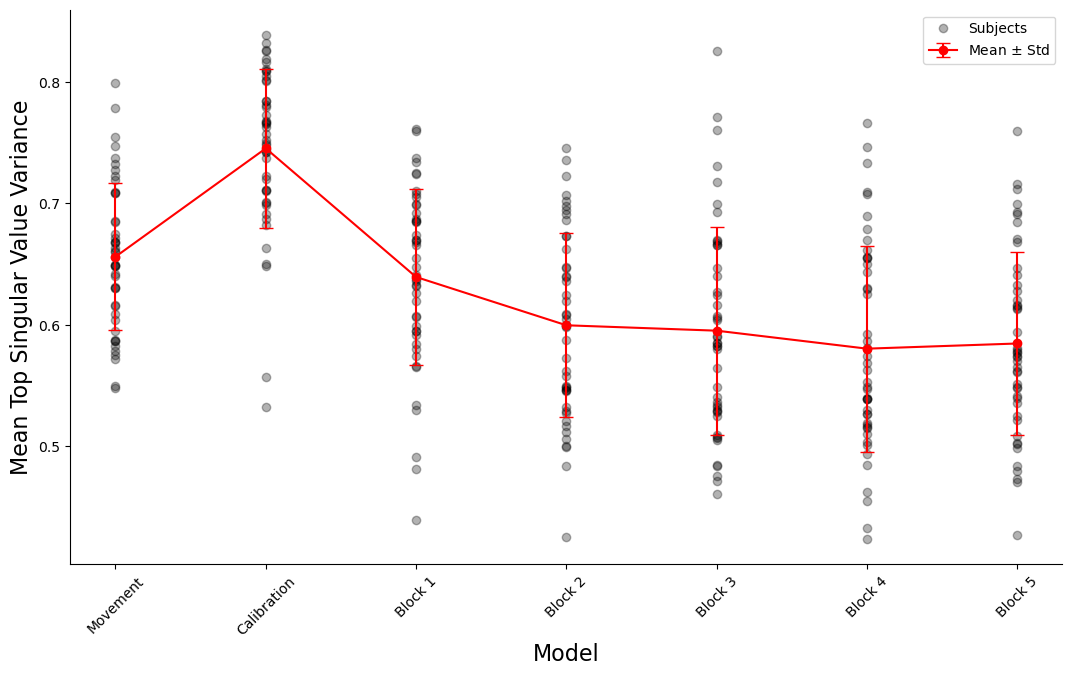

In [6]:
# fig,axes = plt.subplots(1,7,figsize=(40,6))
# for ax in axes:
#     ax.set_xlim([0,1])

grand_means = []
grand_sds = []
mean_svs = []

n_sing_vals = 2

rank_fig = plt.figure()
# subjects, model, component, singular vals
s = np.zeros(shape=(46,12))
for subject_idx in range(len(subjects)):
    for i, m in enumerate(model.load_log_movement_models(subject_idx)):
        # each model over time
        for k, cov in enumerate(m.covariances_):
            # svd of each of the 4 components
            U, S, V = np.linalg.svd(cov)
            s[subject_idx,k] = (S[:n_sing_vals]/S.sum()).reshape(-1)[0]            
mean_sv = np.mean(s,axis=(1))
mean_svs.append(mean_sv)
plt.plot(np.zeros_like(mean_sv),mean_sv,"ko",alpha=0.3,label="Subjects")
grand_means.append(np.mean(mean_sv))
grand_sds.append(np.std(mean_sv))
# axes[1].hist(mean_sv,alpha=0.5,density=True,bins=5)

# subjects, model, component, singular vals
s = np.zeros(shape=(46,12))
for subject_idx in range(len(subjects)):
    for i, m in enumerate(model.load_log_calibration_models(subject_idx)):
        # each model over time
        for k, cov in enumerate(m.covariances_):
            # svd of each of the 4 components
            U, S, V = np.linalg.svd(cov)
            s[subject_idx,k] = (S[:n_sing_vals]/S.sum()).reshape(-1)[0]            
mean_sv = np.mean(s,axis=(1))
mean_svs.append(mean_sv)
plt.plot(np.ones_like(mean_sv),mean_sv,"ko",alpha=0.3)
grand_means.append(np.mean(mean_sv))
grand_sds.append(np.std(mean_sv))
# axes[0].hist(mean_sv,alpha=0.5,density=True,bins=5)

# subjects, model, component, singular vals
for model_idx in range(5):
    s = np.zeros(shape=(46,12))
    for subject_idx in range(len(subjects)):
        m = model.load_log_trial_models(subject_idx)[model_idx]
        # each model over time
        for k, cov in enumerate(m.covariances_):
            # svd of each of the 4 components
            U, S, V = np.linalg.svd(cov)
            s[subject_idx,k] = (S[:n_sing_vals]/S.sum()).reshape(-1)[0]
    mean_sv = np.mean(s,axis=(1))
    plt.plot((model_idx+2)*np.ones_like(mean_sv),mean_sv,"ko",alpha=0.3)
    mean_svs.append(mean_sv)
    grand_means.append(np.mean(mean_sv))
    grand_sds.append(np.std(mean_sv))
    # axes[model_idx+2].hist(mean_sv,alpha=0.5,density=True,bins=5)

plt.errorbar(list(range(7)),grand_means,yerr=grand_sds,color="r",capsize=5,linestyle="-",marker="o",label=f"Mean $\pm$ Std")
plt.ylabel("Mean Top Singular Value Variance")
plt.xlabel("Model")
plt.legend()

xlabels = ["Movement","Calibration","Block 1","Block 2","Block 3","Block 4","Block 5"]
_ = plt.xticks(ticks=range(7),labels=xlabels,rotation=45)

In [7]:
plot.save_figure(rank_fig, "gmm_rank", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/gmm_rank.pdf


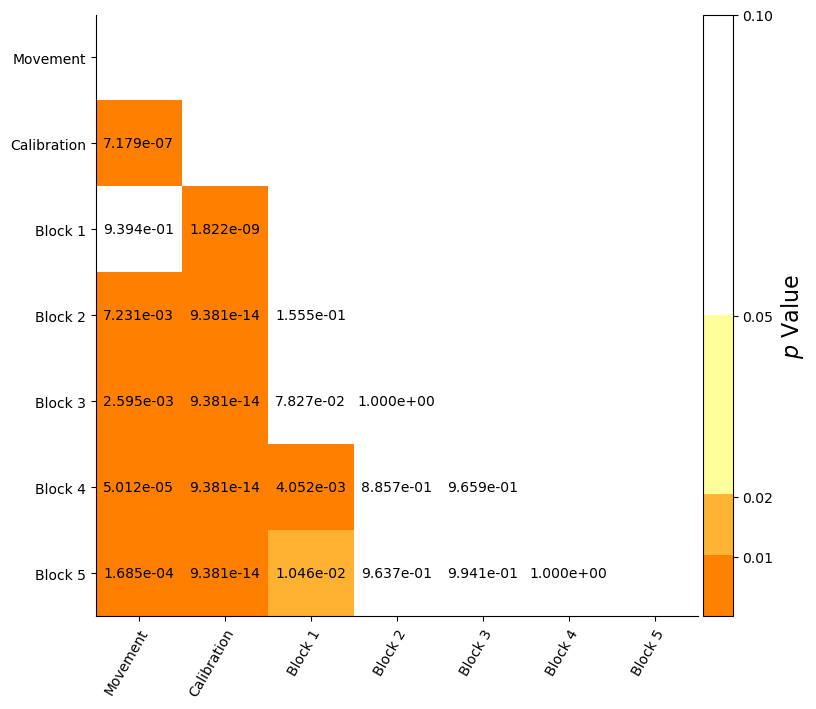

In [8]:
from scipy.stats import tukey_hsd
result = tukey_hsd(*(np.array(mean_svs)))
rank_pvalue_fig, _ = plot.annotated_heatmap(result.pvalue,xlabels,xlabels)
rank_pvalue_fig.tight_layout()

In [9]:
plot.save_figure(rank_pvalue_fig, "gmm_rank_pvalues", image_path, format="png")

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/gmm_rank_pvalues.png


## subspace confinement of calib vs. reward

0.5270936691948105
0.03913357771563691
1.1065897864691863e-06
1.4540809380762312e-07
1.6844442429388707e-06
4.15692745735095e-06
0.0004952844584697641


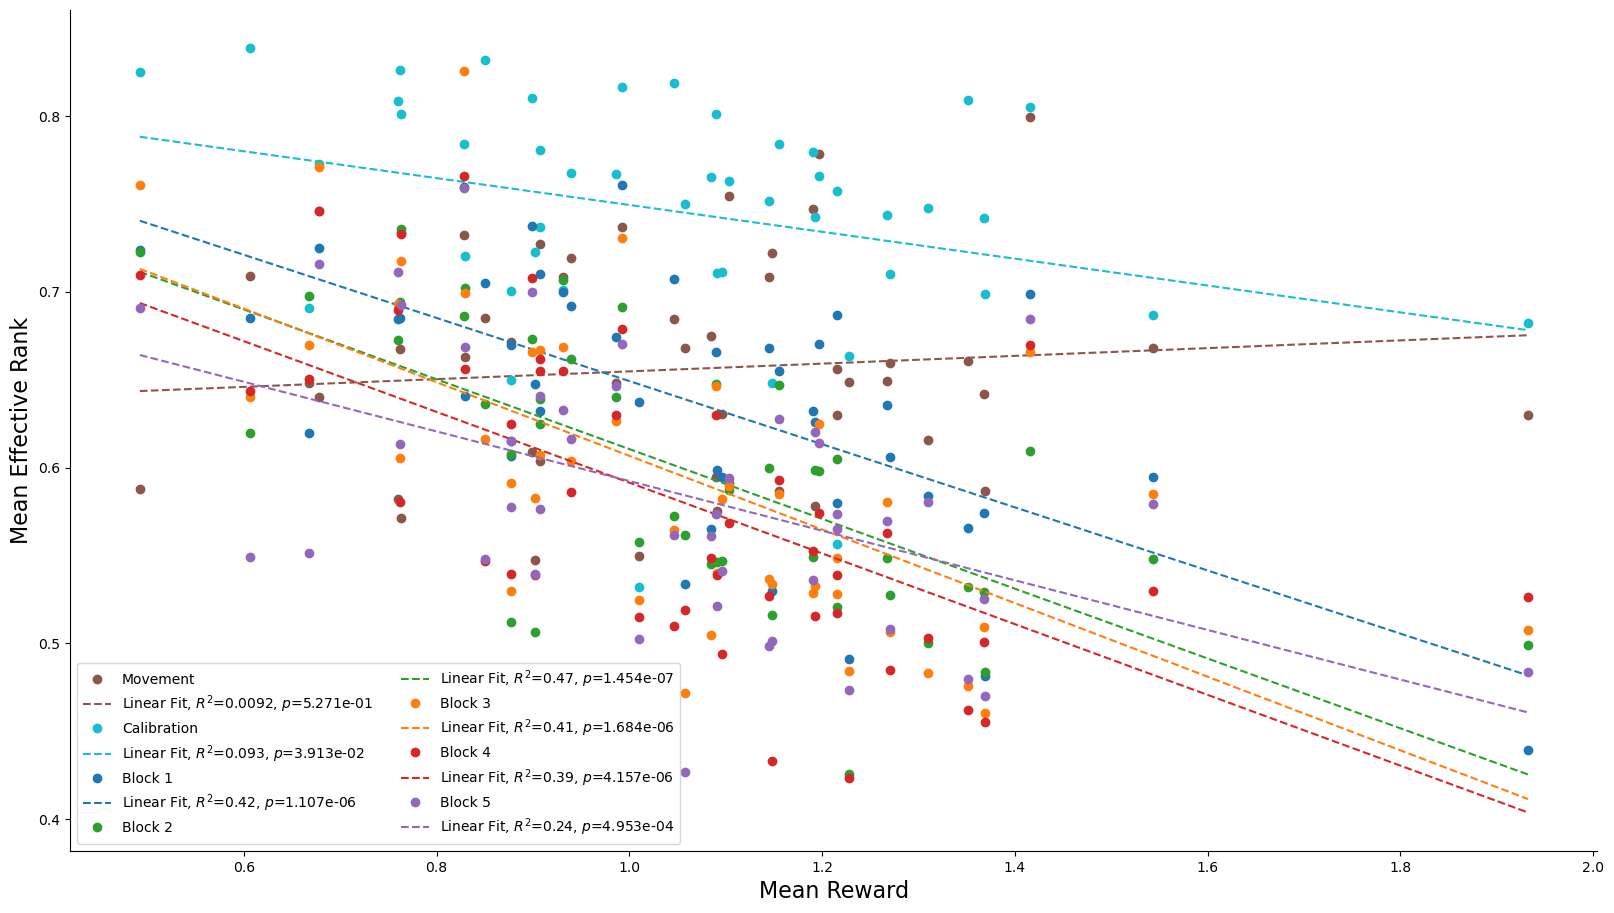

In [8]:
# subjects, model, component, singular vals
fig, ax = plt.subplots(1,1,figsize=(16,9))
fig.tight_layout()
c = ["tab:brown","tab:cyan","tab:blue","tab:green","tab:orange","tab:red","tab:purple",""]
for i, mean_sv in enumerate(mean_svs):
    ax.plot(mean_rewards,mean_sv,'o',color=c[i],label=xlabels[i])
    res = analysis.linear_fit(mean_rewards, mean_sv)
    x = np.linspace(mean_rewards.min(),mean_rewards.max(),100)
    plot.plot_linear_fit(x, res, ax, color=c[i])
    ax.legend(ncols=2)
    ax.set_ylabel("Mean Effective Rank")
    ax.set_xlabel("Mean Reward")
    print(res.pvalue)

In [9]:
plot.save_figure(fig, "rank_vs_reward", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/rank_vs_reward.pdf


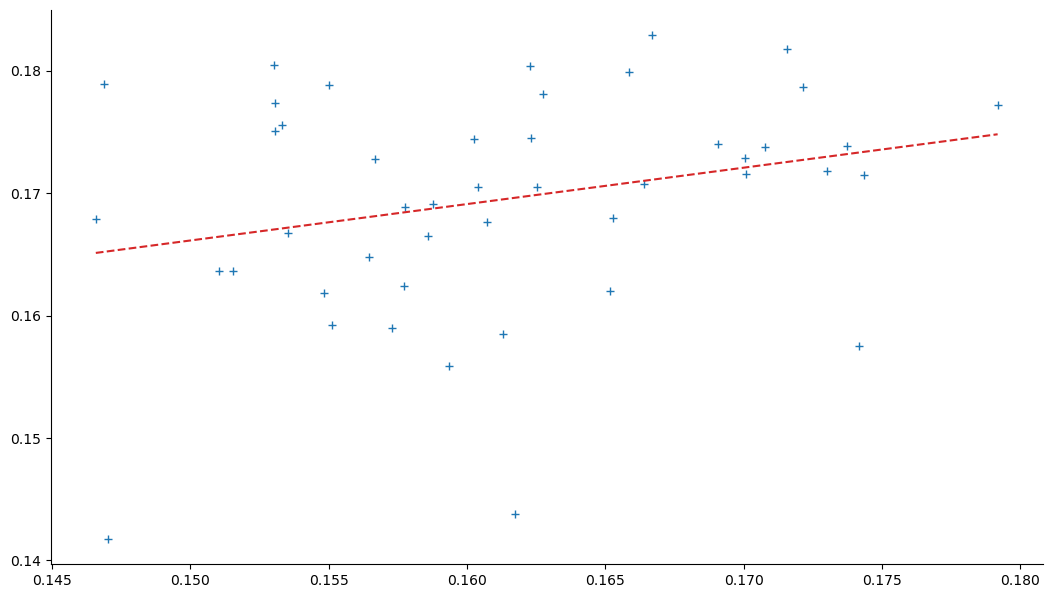

In [43]:
plt.plot(mean_sv_move,mean_sv_calib)
res = analysis.linear_fit(mean_sv_move, mean_sv_calib)
x = np.linspace(mean_sv_move.min(),mean_sv_move.max(),100)
plot.plot_linear_fit(x, res, plt.gca())